<a href="https://colab.research.google.com/github/fcornetti/CataractPredictionCNN/blob/main/Cataract_prediction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://visionplusmag.com/wp-content/uploads/sites/2/2019/03/Fotolia_199220556_Subscription_Monthly_M.jpg)  

# <center>**Eye cataract prediction: binary classification through CNN**</center>

## <div align="right">Francesco Cornetti</div>


---


## Main blocks and key features:

> 1. **Data preprocessing**: custom implemented train_test_validation_split method, data augmentation
> 2. **CNN model**: transfer learning (VGG19 model), with fine tuning
> 3. **Visualization**: kernels, convolved features, heatmaps



---
## Adopted approach:

> Really Small dataset --> High risk of Overfitting --> Data Augmentation and Transfer Learning to regularize. Also, fine tuning to improve performance

---

## Data source
https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k



Data preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

In [ ]:
pathData = '/content/drive/MyDrive/Colab Notebooks/ODIR-5K/ODIR-5K/data.xlsx'
df = pd.read_excel(pathData)
df.head(3)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  ...  C  A  H  M  O
0   0           69      Female  0_left.jpg  0_right.jpg  ...  1  0  0  0  0
1   1           57        Male  1_left.jpg  1_right.jpg  ...  0  0  0  0  0
2   2           42        Male  2_left.jpg  2_right.jpg  ...  0  0  0  0  1

[3 rows x 15 columns]

> <h3> Extracting Cataract & Normal information from the Dataset </h3>

In [ ]:
def has_cataract(text):
    return ("cataract" in text)*1 

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [ ]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values

In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
np.unique(cataract).shape, np.unique(normal).shape 

((313,), (500,))

In [ ]:
pathImages = '/content/drive/MyDrive/Colab Notebooks/ODIR-5K/ODIR-5K/preprocessed_images/'

total = np.concatenate((cataract,normal))
tot = [pathImages+b for b in total] 
classes = ["cataract"]*len(cataract) + ["normal"]*len(normal) 

In [ ]:
extract_code = lambda x: (x.split("/")[-1].split("_")[:-1])[-1]

In [ ]:
df  = pd.DataFrame({"path":tot, "class":classes})
df.head()

path     class
0  /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract
1  /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract
2  /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract
3  /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract
4  /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract

> "Duplicated" = patient has both left and right eye involved → test ***or*** validation, othrwise the learning process could be "corrupted" = the sets have to be strictly independent, without influencing one another.

In [ ]:
def get_unique_and_duplicated_indeces(data_list):

  duplicated_indeces = []
  single_indeces = [] 

  for i, x in enumerate(data_list): 
    if data_list.count(x) > 1:
      duplicated_indeces.append(i)
    else:
        single_indeces.append(i)

  return (duplicated_indeces, single_indeces)

In [ ]:
cataract_codes = [int(extract_code(x)) for x in cataract]
normal_codes = [int(extract_code(x)) for x in normal]

In [ ]:
duplicated_cataract_indeces, single_cataract_indeces = get_unique_and_duplicated_indeces(cataract_codes)
duplicated_normal_indeces, singles_normal_indeces = get_unique_and_duplicated_indeces(normal_codes)

In [ ]:
from sklearn.utils import shuffle

def or_train_or_test_or_val_split_list_with_duplicates(array_list, split_rate, random_state): 

  array_list_sorted_tot = sorted(array_list)

  array_list_sorted = array_list_sorted_tot[0:len(array_list)-1:2]  
      
  array_list_shufled = shuffle(array_list_sorted, random_state=random_state)

  shuffled_indexes = []
  for i in array_list_shufled:
    shuffled_indexes.append(array_list_sorted.index(i))

  array_list_coupled = []
  counter = 0
  for i in array_list_shufled:
      array_list_coupled.append(i)   
      array_list_coupled.append(array_list_sorted_tot[2*shuffled_indexes[counter]+1])
      array_list_coupled
      counter+=1

  int_porcentage_limit = int(len(array_list_coupled)*split_rate)
  if int_porcentage_limit % 2 != 0:
    int_porcentage_limit += 1

  train_duplicates_ = list(array_list_coupled[:int_porcentage_limit]) 
  test_duplicates = list(array_list_coupled[int_porcentage_limit:len(array_list_coupled)])

  int_porcentage_limit_train_val = int(len(train_duplicates_)*round(1-split_rate,1)) 
  if int_porcentage_limit_train_val % 2 != 0:
      int_porcentage_limit_train_val+= 1
  val_duplicates = list(train_duplicates_[:int_porcentage_limit_train_val])
  train_duplicates = list(train_duplicates_[int_porcentage_limit_train_val:len(train_duplicates_)])

  return (train_duplicates, val_duplicates, test_duplicates)

In [ ]:
# cataract "duplicates"

cataract_duplicate_jpgs = cataract[duplicated_cataract_indeces]
train_cataract_duplicates, val_cataract_duplicates, test_cataract_duplicates = or_train_or_test_or_val_split_list_with_duplicates(cataract_duplicate_jpgs, 0.8, 0)

In [ ]:
# normal "duplicates"

normal_duplicate_jpgs = normal[duplicated_normal_indeces]
train_normal_duplicates, val_normal_duplicates, test_normal_duplicates = or_train_or_test_or_val_split_list_with_duplicates(normal_duplicate_jpgs, 0.8, 1)

In [ ]:
# cataract and normal single

from sklearn.model_selection import train_test_split

cataract_single_jpgs = cataract[single_cataract_indeces]
normal_single_jpgs = normal[singles_normal_indeces]

tr_aux_cataract_singles, test_cataract_singles = train_test_split(cataract_single_jpgs, test_size=0.2,
                                                    random_state=1)
train_cataract_singles, val_cataract_singles = train_test_split(tr_aux_cataract_singles, test_size=0.2,
                                                 random_state=3)
tr_aux_normal_singles, test_normal_singles = train_test_split(normal_single_jpgs, test_size=0.2,
                                                        random_state=2)
train_normal_singles, val_normal_singles = train_test_split(tr_aux_normal_singles, test_size=0.2,
                                                     random_state=4)

In [ ]:
train_singles = (np.append(train_cataract_singles, train_normal_singles)).tolist()
train_total = train_singles + train_normal_duplicates + train_cataract_duplicates

test_singles = (np.append(test_cataract_singles, test_normal_singles)).tolist()
test_total = test_singles + test_normal_duplicates + test_cataract_duplicates

val_singles = (np.append(val_cataract_singles, val_normal_singles)).tolist()
val_total = val_singles + val_normal_duplicates + val_cataract_duplicates

In [ ]:
len(train_total), len(test_total), len(val_total) 

(519, 163, 131)

In [ ]:
indexes_tr = [list(total).index(name) for name in train_total] 
df_train = df.iloc[indexes_tr]
df_train.head()

path     class
227  /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract
96   /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract
112  /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract
19   /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract
28   /content/drive/MyDrive/Colab Notebooks/ODIR-5K...  cataract

In [ ]:
indexes_test = [list(total).index(name) for name in test_total] 
df_test = df.iloc[indexes_test]

In [ ]:
indexes_val = [list(total).index(name) for name in val_total]
df_val = df.iloc[indexes_val]

In [ ]:
df_train.shape, df_test.shape, df_val.shape

((519, 2), (163, 2), (131, 2))

In [ ]:
preprocess_input = lambda x:x/255.

Data Augmentation


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input, 
		rotation_range = 20, 
		shear_range = 0.1, 
		zoom_range = 0.05,
		horizontal_flip = True,
		brightness_range = (0.5, 1.5))

val_datagen = ImageDataGenerator(dtype='float32', preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function = preprocess_input)

In [ ]:
batch_size = 32
normed_dims = (224, 224)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col = "path",
    y_col = "class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True, 
    class_mode='categorical') 

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col = "path",
    y_col = "class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col = "path",
    y_col = "class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 513 validated image filenames belonging to 2 classes.
Found 129 validated image filenames belonging to 2 classes.
Found 161 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
number_train_samples = train_generator.n
number_val_samples   = val_generator.n
number_test_samples  = test_generator.n

print(number_train_samples, number_val_samples, number_test_samples)
train_generator.class_indices

513 129 161


{'cataract': 0, 'normal': 1}

In [ ]:
from glob import glob
from random import randrange

randnum = randrange(train_generator.n+val_generator.n+test_generator.n)
folder = glob("/content/drive/MyDrive/Colab Notebooks/ODIR-5K/ODIR-5K/preprocessed_images/*.jpg")
folder[randnum] 

'/content/drive/MyDrive/Colab Notebooks/ODIR-5K/ODIR-5K/preprocessed_images/721_left.jpg'

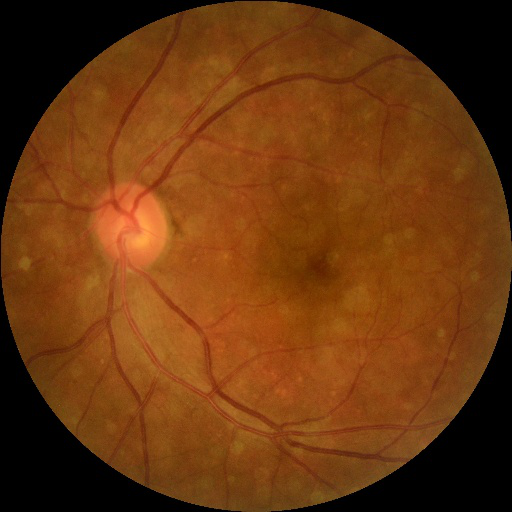

(512, 512, 3) 



In [ ]:
image = load_img(folder[randnum]) 
display(image)
print(np.array(image).shape, "\n")

(1, 512, 512, 3) 



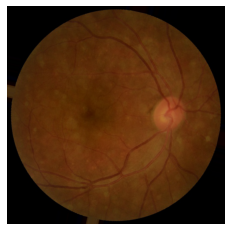

In [ ]:
# data augmented image check visualization 

image_num = np.expand_dims(np.array(image), axis=0)
print(np.array(image_num ).shape, "\n")
plt.imshow(train_datagen.flow(image_num )[0][0])
plt.axis("off");

# **CNN final model**
Here it has been reported only the very last "final" model. It is the result of several experiment and this evolution "journey" has been described inside the presentation. Previous models have been traced in different notebooks for the sake of clarity, due to their experimental use.

In [ ]:
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg = VGG19(weights="imagenet",include_top = False,input_shape=(normed_dims[0],normed_dims[1],3))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
last_layer_unfreeze = 20
for layer in vgg.layers[:last_layer_unfreeze]:
    layer.trainable = False

In [ ]:
classer = GlobalAveragePooling2D()(vgg.layers[-1].output) 
output = Dense(2, activation='softmax')(classer) 
model = Model(inputs=vgg.inputs, outputs=output)

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

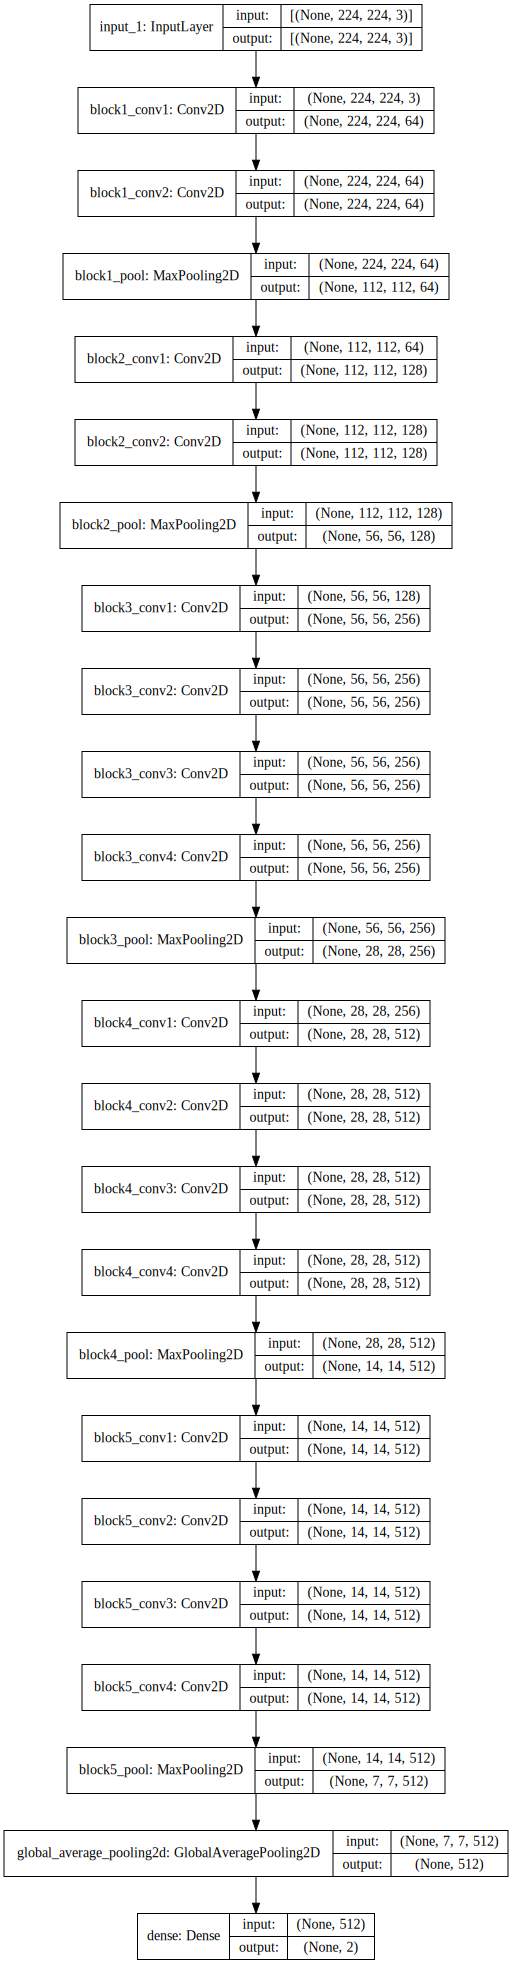

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, dpi=72
                 ).create(prog='dot', format='svg'))

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot_train(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from IPython.display import SVG, display, clear_output

acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1e6
acum_tr_loss  = []
acum_val_loss = []

epochs = 30

modelpath="vgg19_best_model.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max')
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)
callbacks_list = [checkpoint, earlystop]

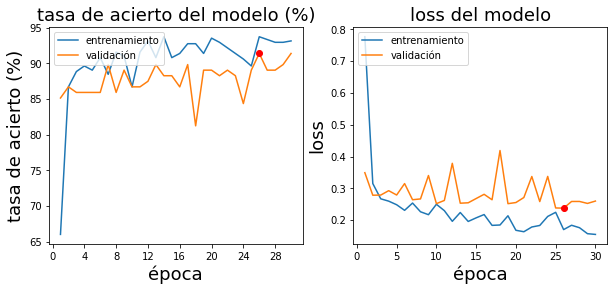

In [ ]:
for e in range(epochs):
    hist_vgg19 = model.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=val_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if hist_vgg19.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', hist_vgg19.history['val_accuracy'])
        print("saving weights")
        best_val_acc = hist_vgg19.history['val_accuracy'][-1]
    
    acum_tr_acc.append(hist_vgg19.history['accuracy'][0])
    acum_val_acc.append(hist_vgg19.history['val_accuracy'][0])
    acum_tr_loss.append(hist_vgg19.history['loss'][0])
    acum_val_loss.append(hist_vgg19.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        plot_train(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
scores_tr = model.evaluate(train_generator) 
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model.evaluate(val_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

17/17 [==============================] - 10s 574ms/step - loss: 0.1684 - accuracy: 0.9201
Train loss    : 0.1683684140443802
Train accuracy: 0.9200779795646667
5/5 [==============================] - 1s 171ms/step - loss: 0.2580 - accuracy: 0.9147
Val loss    : 0.25797224044799805
Val accuracy: 0.9147287011146545
6/6 [==============================] - 36s 7s/step - loss: 0.2099 - accuracy: 0.9379
Test loss     : 0.2098955661058426
Test accuracy : 0.9378882050514221


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc 

y_real = np.array(test_generator.classes) 
y_pred_probabs = model.predict(test_generator) 
y_pred = np.argmax(y_pred_probabs, axis=1)

print(classification_report(y_real, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92        61
           1       0.97      0.93      0.95       100

    accuracy                           0.94       161
   macro avg       0.93      0.94      0.93       161
weighted avg       0.94      0.94      0.94       161



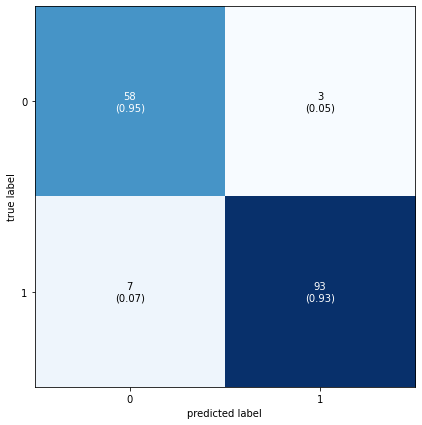

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_real, y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7), show_normed = True);

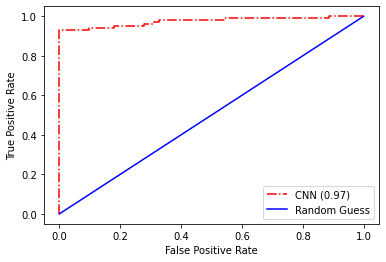

In [ ]:
fpr, tpr, thresholds = roc_curve(y_real , y_pred_probabs[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

Visualization

In [ ]:
weights = model.get_weights() 

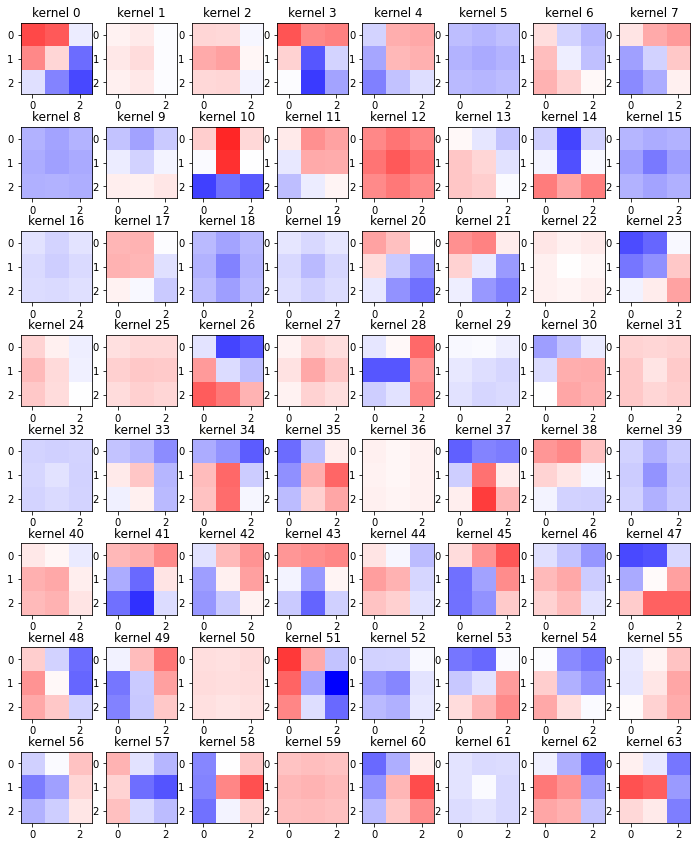

In [ ]:
nfilters = weights[0].shape[3] 
dim = int(np.ceil(np.sqrt(nfilters)))
plt.subplots(dim,dim,figsize = (12, 15))
maximum = abs(weights[0]).max()

for i in range(nfilters):
    kernel = weights[0][:,:,1,i] 
    plt.subplot(dim,dim,i+1)
    plt.imshow(kernel, vmin=-maximum, vmax=maximum, cmap='bwr')
    plt.title('kernel %d' % i)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


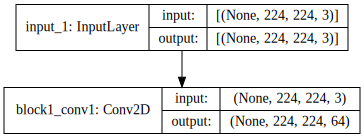

In [ ]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[1].output)
intermediate_layer_model.summary()
SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In [ ]:
test_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

test_generator2 = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col = "path",
    y_col = "class",
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='categorical') 

Found 161 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
X_te, y_te = test_generator2.next()

In [ ]:
y_te_bin = np.argmax(y_te,1)

In [ ]:
class_indices = test_generator2.class_indices

In [ ]:
image = X_te[random.choice(np.where(y_te_bin==1)[0]),:,:]
outs_layer0 = intermediate_layer_model.predict(image.reshape([1,image.shape[0],
                                                                 image.shape[1],image.shape[2]]))
outs_layer0.shape

(1, 224, 224, 64)

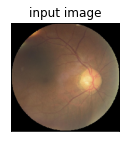

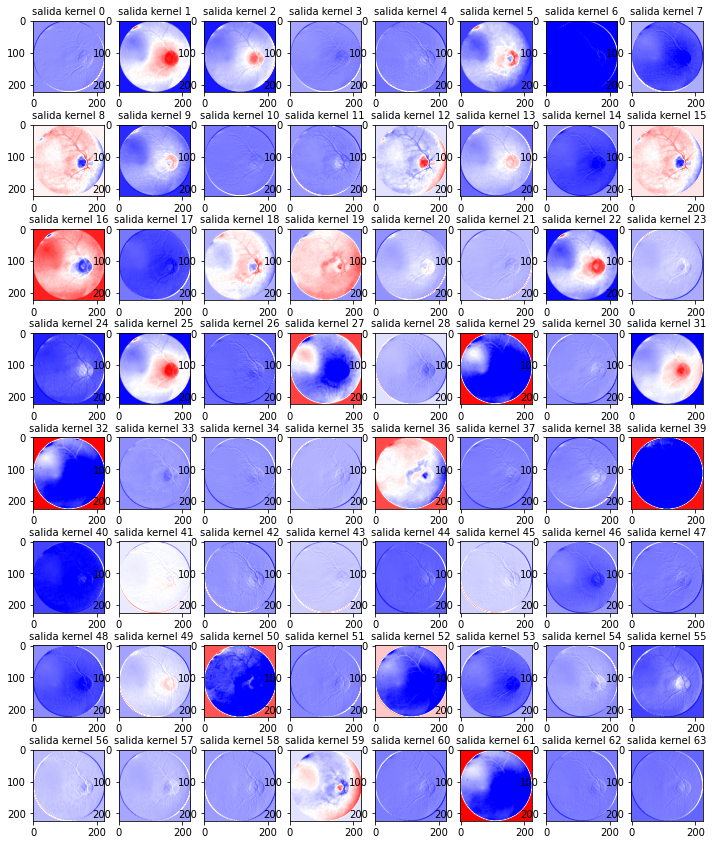

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(image, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

plt.subplots(dim,dim,figsize = (12, 15))

for i in range(outs_layer0.shape[-1]):
    plt.subplot(dim,dim,i+1)
    plt.imshow(outs_layer0[0,:,:,i], cmap='bwr') 
    plt.title('salida kernel %d' % i, fontsize=10)
plt.show()

In [ ]:
def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer

Heat Maps: Grad-Cam

In [ ]:
from keras import backend as K
import tensorflow as tf

def show_heatmap(model, im, res_im): 
    imag = np.expand_dims(im, axis=0) 
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]

    with tf.GradientTape() as tape:

        aux = model.output
        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        # gradient computation between class output and last convolutional layer output
        grads = tape.gradient(class_out, last_conv_layer) 
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) 
    heatmap /= np.max(heatmap) 
    heatmap = heatmap[0] 
    
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    superimposed_img = heatmap * 0.5 + 0.5*im
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()

    if (res_im==0): 
        res_str='cataract'
    else:
        res_str='normal'
    print(res_str) 
    
    prob = 100*model.predict(imag)[0][class_indices["cataract"]]
    print("Probabilidad clase cataract: {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["normal"]]
    print("Probabilidad clase normal: {:2.1f}%".format(prob))
    print("\n\n")

    return heatmap, superimposed_img

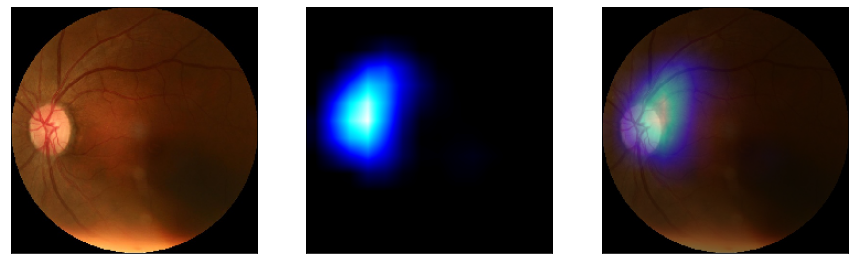

normal
Probabilidad clase cataract: 0.0%
Probabilidad clase normal: 100.0%





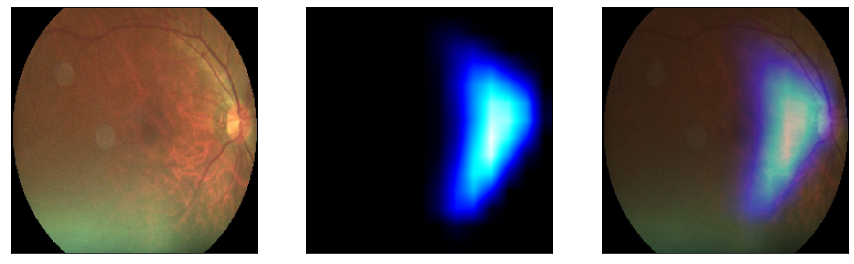

normal
Probabilidad clase cataract: 0.1%
Probabilidad clase normal: 99.9%





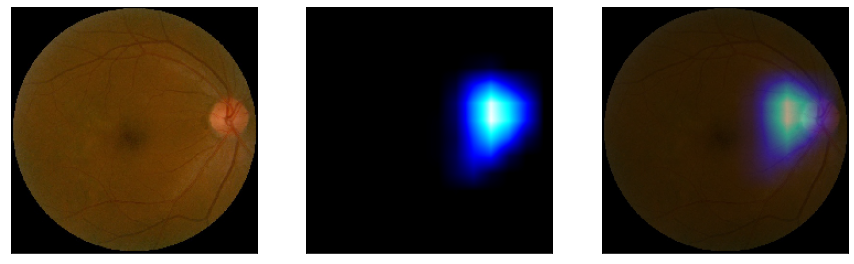

normal
Probabilidad clase cataract: 6.7%
Probabilidad clase normal: 93.3%





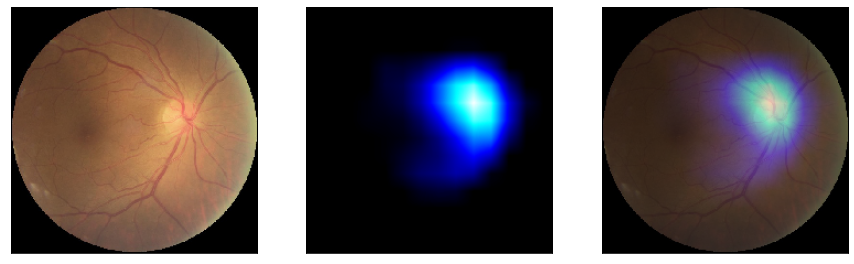

normal
Probabilidad clase cataract: 0.6%
Probabilidad clase normal: 99.4%





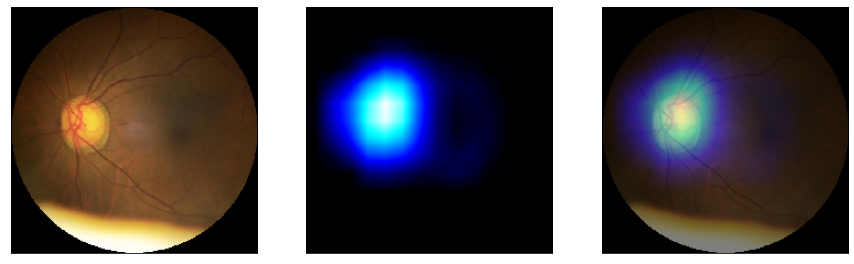

normal
Probabilidad clase cataract: 0.0%
Probabilidad clase normal: 100.0%





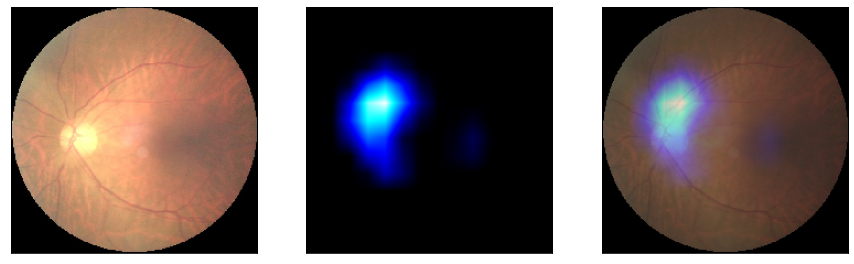

cataract
Probabilidad clase cataract: 33.2%
Probabilidad clase normal: 66.8%





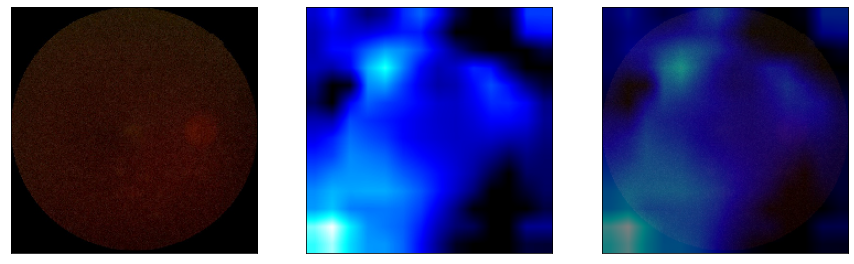

cataract
Probabilidad clase cataract: 70.0%
Probabilidad clase normal: 30.0%





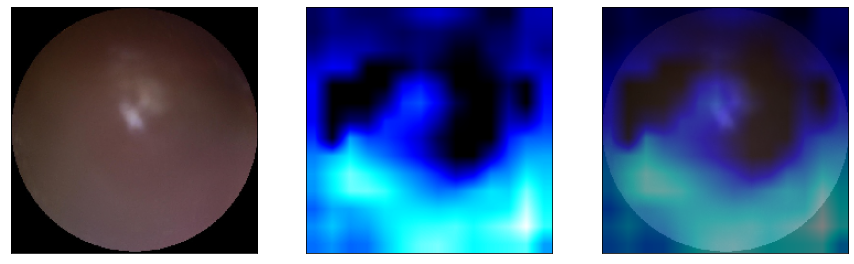

cataract
Probabilidad clase cataract: 84.1%
Probabilidad clase normal: 15.9%





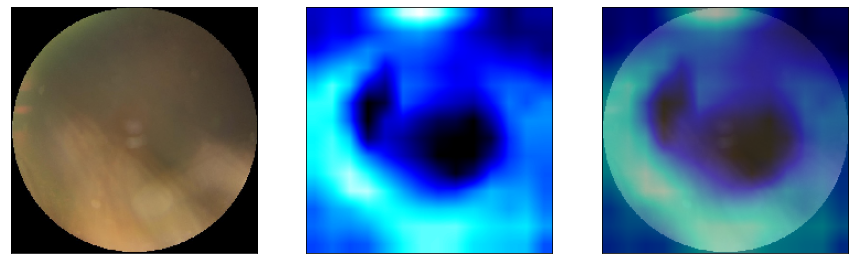

cataract
Probabilidad clase cataract: 98.7%
Probabilidad clase normal: 1.3%





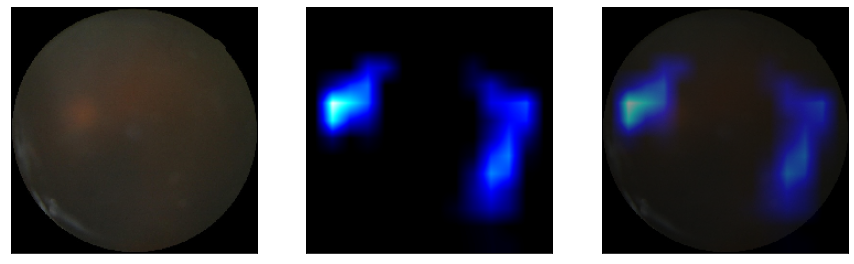

cataract
Probabilidad clase cataract: 47.5%
Probabilidad clase normal: 52.5%





In [ ]:
from random import seed
from random import randint

seed(1)

sample_to_show = 5 
normal_test2_indexes = np.where(y_te_bin == class_indices['normal'])[0]
normal_test2_indexes_sample = normal_test2_indexes[np.random.choice(len(normal_test2_indexes), size=5, replace=False)]

cataract_test2_indexes = np.where(y_te_bin == class_indices['cataract'])[0]
cataract_test2_indexes_sample = cataract_test2_indexes[np.random.choice(len(cataract_test2_indexes), size=5, replace=False)]

for i in np.append(normal_test2_indexes_sample, cataract_test2_indexes_sample):
	heatmap,superponed_img = show_heatmap(model, X_te[i], y_te_bin[i]) 

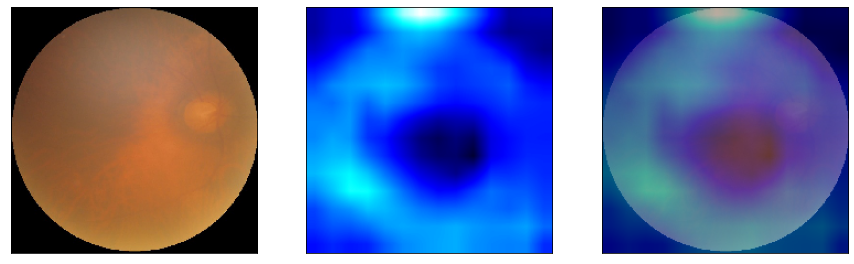

normal
Probabilidad clase cataract: 99.7%
Probabilidad clase normal: 0.3%





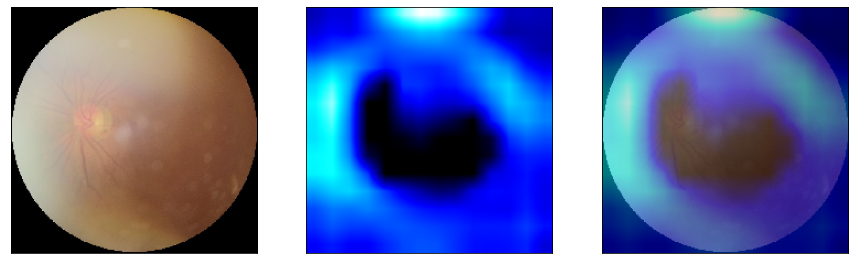

normal
Probabilidad clase cataract: 98.9%
Probabilidad clase normal: 1.1%





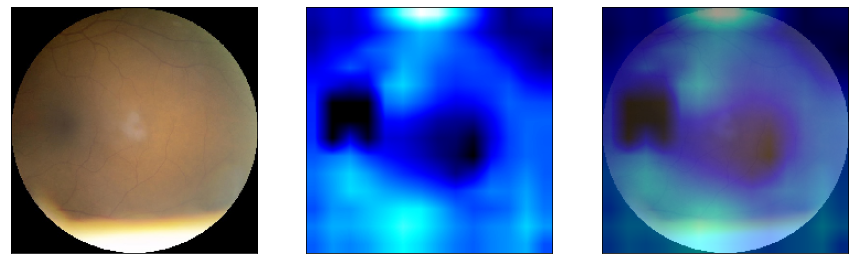

normal
Probabilidad clase cataract: 97.7%
Probabilidad clase normal: 2.3%





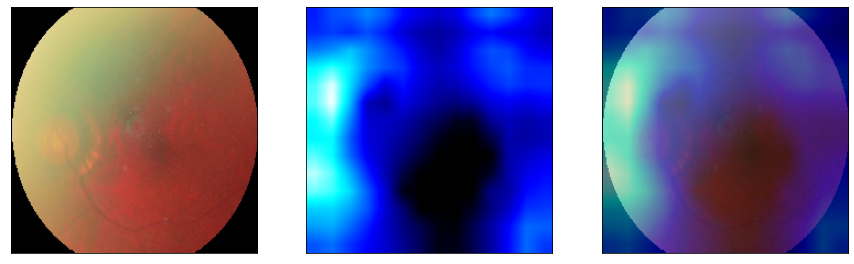

normal
Probabilidad clase cataract: 97.2%
Probabilidad clase normal: 2.8%





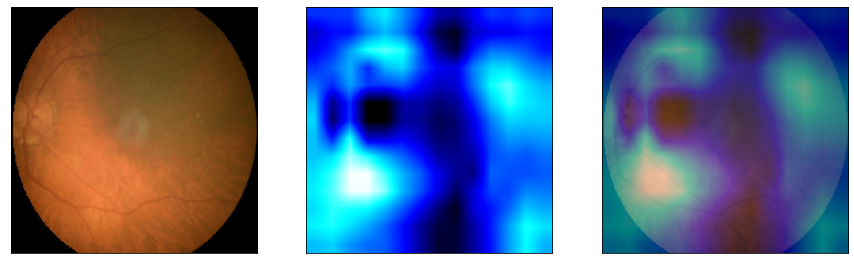

normal
Probabilidad clase cataract: 94.7%
Probabilidad clase normal: 5.3%





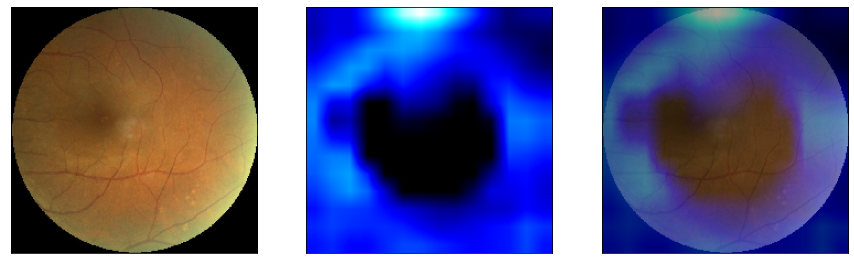

normal
Probabilidad clase cataract: 86.5%
Probabilidad clase normal: 13.5%





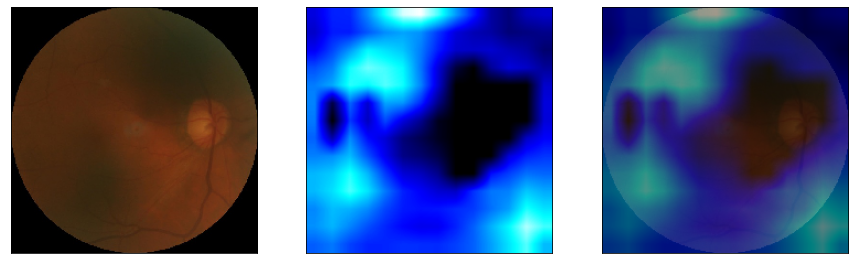

normal
Probabilidad clase cataract: 76.0%
Probabilidad clase normal: 24.0%





In [ ]:
# worst network mistakes

normal_test2_indexes = np.where(y_te_bin==class_indices["normal"])[0] 
normal_test2_indexes = sorted(normal_test2_indexes, key=lambda i:y_pred_probabs[i][class_indices["normal"]])
FP = cm[1][0]
for i in normal_test2_indexes[:FP]: 
    show_heatmap(model, X_te[i], y_te_bin[i])

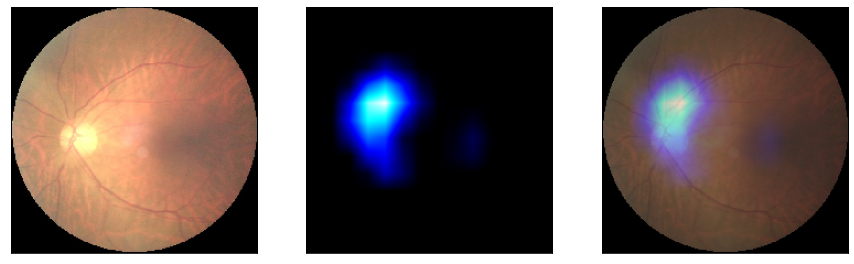

cataract
Probabilidad clase cataract: 33.2%
Probabilidad clase normal: 66.8%





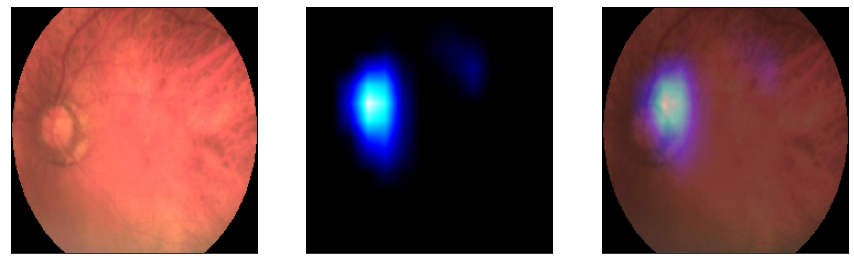

cataract
Probabilidad clase cataract: 35.4%
Probabilidad clase normal: 64.6%





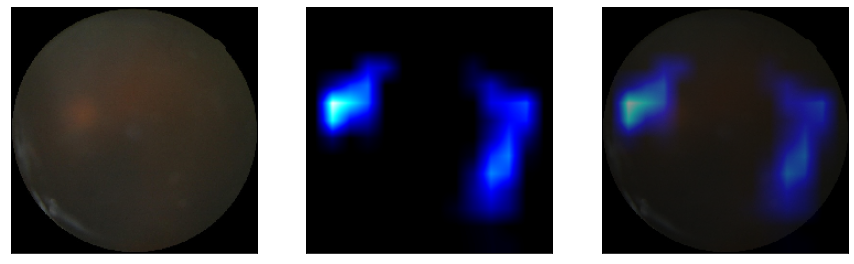

cataract
Probabilidad clase cataract: 47.5%
Probabilidad clase normal: 52.5%





In [ ]:
cataract_test2_indexes = np.where(y_te_bin==class_indices["cataract"])[0] 
cataract_test2_indexes = sorted(cataract_test2_indexes, key=lambda i:y_pred_probabs[i][class_indices["cataract"]])
FN = cm[0][1]
for i in cataract_test2_indexes[:FN]: 
    show_heatmap(model, X_te[i], y_te_bin[i])